# <center>EDSA MOVIE RECOMMENDATION 2022</center>

Recommendation systems predict a user's rating or preference for an item. In this case, we are dealingn with movies from the MovieLens dataset. This recommendation system will predict what a given user will rate a movie. 

The algorithm in this notebook carries out its prediction based on similar content, or what is known as a content-based recommendation system. Given a movie that a user has not rated, the algorithm seeks to predict the rating based on the ratings given by the user on past movies. 

## Importing the data 

Explore Data Science Academy (EDSA) has provided us with 8 data files that will be used for predicting user's movie ratings. These data was resampled from the MovieLens dataset for fair evaluation. 

Our task in this section is to merge the files so as to extract the relevant properties from each file and create a dataframe that will be used in prediction. 

In [2]:
# Importing the libraries we'll use 
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

## Let's import the movies data

In [3]:
movies_df = pd.read_csv('movies.csv')

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We can see that the genres properties, which is useful for our purposes, is separated by | character. We now remove the character to make it space delimited strings. 

In [5]:
movies_df['genres'] = movies_df['genres'].str.split('|').str.join(' ')

In [6]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


## the tags data
We'll now take a look at the tags data

In [7]:
tags_df = pd.read_csv('tags.csv')

In [8]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


From the above, we see that one user can tag a single movie more than once. We'll now examine if several users can tag the same movie

In [9]:
# searching for user tags for movie id == 1
tags_df[tags_df['movieId'] == 1]

,userId,movieId,tag,timestamp
2306,791,1,Owned,1515175493
3749,1048,1,imdb top 250,1172144394
4226,1361,1,Pixar,1216146311
10003,3164,1,Pixar,1223304727
10004,3164,1,time travel,1223304729
...,...,...,...,...
1084685,160835,1,American Animation,1437092829
1084688,160858,1,computer animation,1451035426
1084689,160858,1,pixar,1451035426
1088052,161172,1,Pixar,1159534063


From the above, we can also see that several users can tag the same movie. 

So we need a way to collect all the tags for each movie and put them in the movies_df dataframe. We also need to make sure that each tag is unique. 

In [10]:
def create_movie_tags(x):
    # get the tags list
    tags_list = tags_df[tags_df['movieId'] == x]['tag']
    # convert it to unique values or set
    tags_list = list(set(tags_list))
    final_list = [str(x) for x in tags_list]
    return ', '.join(final_list)




In [11]:
movies_df['tags'] = movies_df['movieId'].apply(create_movie_tags)

In [12]:
movies_df.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute..."
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams..."
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar..."
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no..."
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d..."


In [13]:
movies_df['movieId'].nunique()

62423

## Imdb data



Imdb means the Internet Movie database. it is an onliine database with information and statistics about movies. This database contains interesting properties of movies such as title cast, director, runtime, budget and plot keywords. 

In [14]:
# importing the imdb database
imdb_df = pd.read_csv('imdb_data.csv')

In [15]:
# taking a look at the database. The first five rows
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


The properties of interest from the imdb database are title_cast, director, runtime, plot_keywords. We left out the budget property for now. 

In [16]:
# removing the | character from title_cast column
imdb_df['title_cast'] = imdb_df['title_cast'].str.split('|').str.join(', ')

In [17]:
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,"Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


We now add the title_cast to the movies dataframe

In [18]:
# creating a function to add title_cast column
def add_title_cast(x):
    # create a series of the movieid column in imdb df
    title_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in title_series.values:
        title_case = imdb_df.loc[imdb_df['movieId'] == x, 'title_cast'].item()
        return title_case
    else:
        return " "         

In [19]:
movies_df['title_cast'] = movies_df['movieId'].apply(add_title_cast)
movies_df.head()

,movieId,title,genres,tags,title_cast
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann..."
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


We then add the director item

In [20]:
# creating a function to add title_cast column
def add_director(x):
    # create a series of the movieid column in imdb df
    director_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in director_series.values:
        director = imdb_df.loc[imdb_df['movieId'] == x, 'director'].item()
        return director
    else:
        return " "         

In [21]:
movies_df['director'] = movies_df['movieId'].apply(add_director)

In [22]:
movies_df.head()

,movieId,title,genres,tags,title_cast,director
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett


Then add the budget

In [23]:
# creating a function to add budget column
def add_budget(x):
    # create a series of the movieid column in imdb df
    budget_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in budget_series.values:
        budget = imdb_df.loc[imdb_df['movieId'] == x, 'budget'].item()
        return budget
    else:
        return " "         

In [24]:
movies_df['budget'] = movies_df['movieId'].apply(add_budget)

In [25]:
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000"
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000"
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000"
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000"
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000"


Before adding the plot keywords, we need to remove the pipe, |, character. 

In [26]:
# removing the | character from plot_keywords column
imdb_df['plot_keywords'] = imdb_df['plot_keywords'].str.split('|').str.join(', ')
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,81.0,"$30,000,000","toy, rivalry, cowboy, cgi animation"
1,2,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,104.0,"$65,000,000","board game, adventurer, fight, game"
2,3,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,101.0,"$25,000,000","boat, lake, neighbor, rivalry"
3,4,"Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,124.0,"$16,000,000","black american, husband wife relationship, bet..."
4,5,"Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,106.0,"$30,000,000","fatherhood, doberman, dog, mansion"


then add the plot_keywords column to movies dataframe

In [27]:
# creating a function to add title_cast column
def add_plot_keywords(x):
    # create a series of the movieid column in imdb df
    plot_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in plot_series.values:
        plot = imdb_df.loc[imdb_df['movieId'] == x, 'plot_keywords'].item()
        return plot
    else:
        return " "         

In [28]:
movies_df['plot_keywords'] = movies_df['movieId'].apply(add_plot_keywords)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy, rivalry, cowboy, cgi animation"
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board game, adventurer, fight, game"
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","boat, lake, neighbor, rivalry"
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","black american, husband wife relationship, bet..."
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","fatherhood, doberman, dog, mansion"


Let's add the runtime from the imdb dataframe to the movies dataframe. 

In [29]:
# creating a function to add title_cast column
def add_runtime(x):
    # create a series of the movieid column in imdb df
    runtime_series = imdb_df['movieId']
    # check if the movieId from the movies df is in the series
    if x in runtime_series.values:
        runtime = imdb_df.loc[imdb_df['movieId'] == x, 'runtime'].item()
        return runtime
    else:
        return np.nan         

In [30]:
movies_df['runtime'] = movies_df['movieId'].apply(add_runtime)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy, rivalry, cowboy, cgi animation",81.0
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board game, adventurer, fight, game",104.0
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","boat, lake, neighbor, rivalry",101.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","black american, husband wife relationship, bet...",124.0
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","fatherhood, doberman, dog, mansion",106.0


In [31]:
# how many movies do we have?
print("The number of books in the movies database is:", movies_df.shape[0])

The number of books in the movies database is: 62423


Let's explore the ratings database. The ratings will be used for predictions. 

In [32]:
# importing the ratings csv file
movie_ratings = pd.read_csv('train.csv')
movie_ratings.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


We'll remove the timestamps from the ratings and then add movie titles to the ratings dataframe.

In [33]:
movie_ratings.drop("timestamp", axis=1, inplace=True)
movie_ratings.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [34]:
movie_ratings['title'] = movie_ratings.merge(movies_df, on=['movieId'], how='left')['title']
movie_ratings.head()


,userId,movieId,rating,title
0,5163,57669,4.0,In Bruges (2008)
1,106343,5,4.5,Father of the Bride Part II (1995)
2,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...
3,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005)
4,9041,366,3.0,Wes Craven's New Nightmare (Nightmare on Elm S...


Let's do an exploratory data analysis of the ratings. 

In [35]:
# how many ratings do we have?
print("The number of ratings are", movie_ratings.shape[0])

The number of ratings are 8226313


Let's see how kind the movie viewers are to movie producers in their ratings. That is, what is the most likely rating given to a movie?

Average rating in dataset: 3.533385065703189


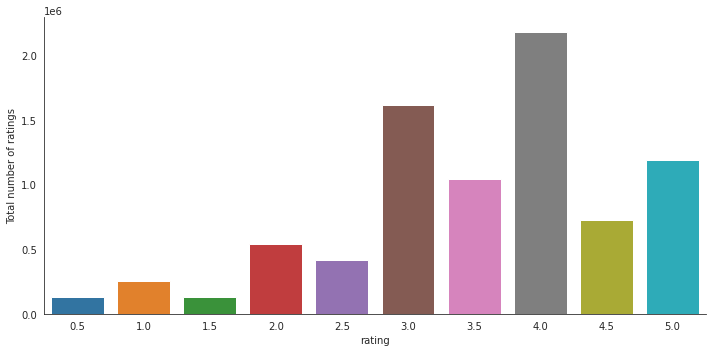

In [36]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=movie_ratings, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(movie_ratings["rating"])}')

From the above statistic and graphic, we can see that movie viewers tend to rate movies high. The mean rating is 3.5 while the modal rating is 4.0.

## Implementation

We'll now implement a simple content-based filtering prediction system. To begin, we will first collect all the properties of the movies into one convenient column. Then we create a titles dataframe and indices dataframe for referencing the movies dataframe. 

In [37]:
movies_df['all_properties'] = (pd.Series(movies_df[['genres', 'tags', 'title_cast', 'director', 'plot_keywords']]
                      .fillna('')
                      .values.tolist()).str.join(' '))
movies_df.head()                      

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,all_properties
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy, rivalry, cowboy, cgi animation",81.0,Adventure Animation Children Comedy Fantasy Tu...
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board game, adventurer, fight, game",104.0,"Adventure Children Fantasy new home, herds of ..."
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","boat, lake, neighbor, rivalry",101.0,"Comedy Romance sequel, best friend, Jack Lemmo..."
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","black american, husband wife relationship, bet...",124.0,"Comedy Drama Romance revenge, interracial rela..."
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","fatherhood, doberman, dog, mansion",106.0,"Comedy Comedy, sequel, sequel fever, baby, Fan..."


On closer examination, we notice that there are non-ascii characters and repeated words in the all_properties column we will be using. So we need to remove those. Also, we have to convert all the words to lower case characters. 

In [38]:
def remove_unwanted(x):
    # remove non-ascii
    text = x.encode("ascii", "ignore").decode()
    # all lower case
    text = text.lower()
    # make the string a concatenated whole by removing commas
    text = text.replace(",", " ")
    # split the string
    text = text.split()
    # remove duplicate words
    final_text = " ".join(sorted(set(text), key=text.index))
    return final_text


In [39]:
movies_df['properties_final'] = movies_df['all_properties'].apply(remove_unwanted)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,all_properties,properties_final
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy, rivalry, cowboy, cgi animation",81.0,Adventure Animation Children Comedy Fantasy Tu...,adventure animation children comedy fantasy tu...
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board game, adventurer, fight, game",104.0,"Adventure Children Fantasy new home, herds of ...",adventure children fantasy new home herds of c...
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","boat, lake, neighbor, rivalry",101.0,"Comedy Romance sequel, best friend, Jack Lemmo...",comedy romance sequel best friend jack lemmon ...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","black american, husband wife relationship, bet...",124.0,"Comedy Drama Romance revenge, interracial rela...",comedy drama romance revenge interracial relat...
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","fatherhood, doberman, dog, mansion",106.0,"Comedy Comedy, sequel, sequel fever, baby, Fan...",comedy sequel fever baby fantasy daughter dian...


we now remove the all_properties column for a nicer dataframe

In [40]:
movies_df.drop("all_properties", axis=1, inplace=True)
movies_df.head()

,movieId,title,genres,tags,title_cast,director,budget,plot_keywords,runtime,properties_final
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,"Tumey's VHS, fanciful, great movie, unny, cute...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"$30,000,000","toy, rivalry, cowboy, cgi animation",81.0,adventure animation children comedy fantasy tu...
1,2,Jumanji (1995),Adventure Children Fantasy,"new home, herds of CGI animals, Robin Williams...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Jonathan Hensleigh,"$65,000,000","board game, adventurer, fight, game",104.0,adventure children fantasy new home herds of c...
2,3,Grumpier Old Men (1995),Comedy Romance,"sequel, best friend, Jack Lemmon, funny, Howar...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Mark Steven Johnson,"$25,000,000","boat, lake, neighbor, rivalry",101.0,comedy romance sequel best friend jack lemmon ...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,"revenge, interracial relationship, based on no...","Whitney Houston, Angela Bassett, Loretta Devin...",Terry McMillan,"$16,000,000","black american, husband wife relationship, bet...",124.0,comedy drama romance revenge interracial relat...
4,5,Father of the Bride Part II (1995),Comedy,"Comedy, sequel, sequel fever, baby, Fantasy, d...","Steve Martin, Diane Keaton, Martin Short, Kimb...",Albert Hackett,"$30,000,000","fatherhood, doberman, dog, mansion",106.0,comedy sequel fever baby fantasy daughter dian...


We noticed that the number of movies we have in the movies dataframe was too much. We now want to examine what movies do not have ratings and remove those so that the GPU on Google Colab will not crash. The GPU keeps crashing because the number of samples for the movie database is very large. From this point, I am stumped and need inspiration. 